# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import time

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction.text import HashingVectorizer


### Format Class
> Created a class to add color or format print statements

In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

### Load Data & Split
> Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

# Splitting the data into training, dev and test.
num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


- Training dataset has around 2000 examples while dev and test are split into around 676 example each.

### Histogram
> Lets look at the distribution of the data within the various classes. 

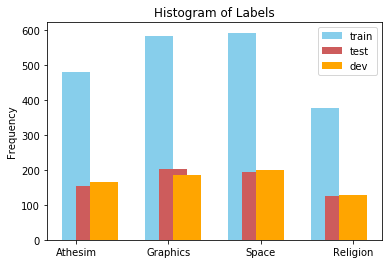

In [4]:
fig, ax = plt.subplots()

rects1 = ax.hist(train_labels,
                color='SkyBlue', label='train', align = 'left')
rects2 = ax.hist(test_labels,
                color='IndianRed', label='test', align = 'mid')
rects3 = ax.hist(dev_labels,
                color='orange', label='dev', align = 'right')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Labels')
ax.set_xticks(np.arange(4))
ax.set_xticklabels(('Athesim', 'Graphics', 'Space', 'Religion'))
ax.legend()

- The data looks to be distributed evenly across all the labels for training, test and development datasets.

In [5]:
print (newsgroups_train.data[1].splitlines(), newsgroups_train.target_names[1])

['', '', 'Seems to be, barring evidence to the contrary, that Koresh was simply', 'another deranged fanatic who thought it neccessary to take a whole bunch of', 'folks with him, children and all, to satisfy his delusional mania. Jim', 'Jones, circa 1993.', '', '', 'Nope - fruitcakes like Koresh have been demonstrating such evil corruption', 'for centuries.'] comp.graphics


### Sample Data
(1) For each of the first 5 training examples, print the text of the message along with the label.

In [5]:
def P1(num_examples=5):
    for i in np.arange(num_examples):
        print (train_data[i], '\n')
        print (bcolors.HEADER, 'Label: ' , train_labels[i] , bcolors.ENDC)
        print ('-------------------------------------------------', '\n')
    return
        
    
P1()

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

 Label:  1 
------------------------------------------------- 



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centur

### Vectorize data
(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [76]:
def P2(data, vocab,analyzer, min_df, ngram_range , details, preprocessor, stop_words):
    feat_vect = CountVectorizer(vocabulary=vocab, analyzer = analyzer, min_df= min_df, 
                                ngram_range = ngram_range, preprocessor = preprocessor, stop_words = stop_words)
    print (feat_vect)
    feat_vect.fit(data)
    dtm_train = feat_vect.transform(data)
    if details == 'Y':
        print (bcolors.BOLD + '\n The size of the vocabulary is:', dtm_train.shape[1])
        print('\n Average length of each example: %.2f' % (dtm_train.nnz /dtm_train.shape[0]))
        print ('\n Amount of Non-Zero occurences: ', dtm_train.nnz)
        print ('\n sparsity: %.2f%%' % (100.0 * dtm_train.nnz /
                                        (dtm_train.shape[0] * dtm_train.shape[1])))
        print ('\n First Feature string: ', feat_vect.get_feature_names()[0])
        print ('\n Last Feature string: ', feat_vect.get_feature_names()[dtm_train.shape[1]-1] + '\n')
    return feat_vect, dtm_train



# Using the vocabulary from the corpus of words within the text
P2(train_data, None, 'word', 1, (1,1), 'Y', None, None)
print ('-------------------------------')
# Using the vocabulary from the corpus of words within the text
P2(train_data, ["atheism", "graphics", "space", "religion"], 'word', 1, (1,1), 'Y', None, None)
print ('-------------------------------')
# Using the vocabulary from the corpus of words while using the character with word bound analyzer and 
# 2-gram character
P2(train_data, None, 'char_wb', 1, (2,2), 'Y', None, None)
print ('-------------------------------')
# Using the vocabulary from the corpus of words while using the character with word bound analyzer and 
# 3-gram character
P2(train_data, None, 'char_wb', 1, (3,3), 'Y', None, None)
print ('-------------------------------')
# Using the vocabulary from the corpus of words while looking for words that appear in more than 10 documents
feat_vec_1, dtm_train_1 = P2(train_data, None, 'word', 10, (1,1), 'Y', None, None)
print ('-------------------------------')
# Count of Vocabular for dev data
feat_vec_1, dtm_train_1 = P2(train_data, None, 'word', 1, (1,1), 'Y', None, None)
feat_vec_2, dtm_train_2 = P2(dev_data, None, 'word', 1, (1,1), 'Y', None, None)
print ('\n Total words that are in the dev data vocabulary but not in training data are:', 
       len(np.unique(list(set(feat_vec_2.get_feature_names()) - set(feat_vec_1.get_feature_names())))))
print ('-------------------------------')


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

 The size of the vocabulary is: 26879

 Average length of each example: 96.71

 Amount of Non-Zero occurences:  196700

 sparsity: 0.36%

 First Feature string:  00

 Last Feature string:  zyxel

-------------------------------
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary=['atheism', 'graphi

**Answers:**

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

> **The size of the vocabulary is: 25864**

> **Average length of each example: 371.46** 

> **Amount of Non-Zero occurences:  755559**

> **sparsity: 1.44%**

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

> **First Feature string:  00**

> **Last Feature string:  zyxel**

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

> **The size of the vocabulary is: 4**

> **Average length of each example: 0.27**

- It is worth nothing that due to limited vocabulary, the length of each example is very low.

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

- For N-Gram of (2,2)
> **The size of the vocabulary is: 3090**

> **Average length of each example: 201.12**

> **Amount of Non-Zero occurences:  409075**

> **sparsity: 6.51%**

- For N-Gram of (3,3)
> **The size of the vocabulary is: 25864**

> **Average length of each example: 371.46**

> **Amount of Non-Zero occurences:  755559**

> **sparsity: 1.44%**

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?
> **The size of the vocabulary is: 3064**

> **Average length of each example: 72.68**

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.
> **Total words that are in the dev data vocabulary but not in training data are: 4027**

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Best score for KNN Classifier : 0.436086529006883
Best parameters for KNN Classifier : {'n_neighbors': 7}

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Best score for Naive Bayes Classifier : 0.828416912487709
Best parameters for Naive Bayes Classifier : {'alpha': 0.01}
Best Score for Naive Bay

/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score for Logistic Regression Classifier : 0.7846607669616519
Best parameters for Logistic Regression Classifier : {'C': 0.1}
Best Score for Logistic Regression Classifier on Train Data : 0.7041420118343196
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Model Score: 0.678994
C values: 0.010000 Weights :10.593705 
Model Score: 0.704142
C values: 0.100000 Weights :102.272602 
Model Score: 0.701183
C values: 1.000000 Weights :601.602336 
Model Score: 0.696746
C values: 2.000000 Weights :921.703600 
Model Score: 0.695266
C values: 3.000000 Weights :1158.221857 
Model Score: 0.693787
C values: 4.000000 Weights :1350.189555 
Model Score: 0.695266
C values: 5.000000

(LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None))

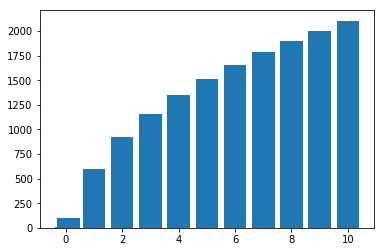

In [30]:
def P3_knn(data, labels, k_value, ngram_range, preprocessor, validation_ind, stop_words, analyzer, min_df, vocab):
    feat_vec, dtm_train = P2(data, vocab, analyzer , min_df, ngram_range, 'N', preprocessor, stop_words)
    dtm_dev = feat_vec.transform(dev_data)
    model = KNeighborsClassifier()
    if validation_ind == 'N':
        model.fit(dtm_train, labels)
        print("*** Model Metrics ***")
        print(classification_report(dev_labels, model.predict(dtm_dev)))
        print ("Model Score: %3f" % model.score(dtm_dev, dev_labels))
    if validation_ind == 'Y':
        gcv = GridSearchCV(model, param_grid = k_value, n_jobs=-1, cv = 5)
        gcv.fit(dtm_train, labels)
        print(bcolors.BOLD + 'Best score for KNN Classifier :', gcv.best_score_)
        print('Best parameters for KNN Classifier :', gcv.best_params_)
        print(bcolors.ENDC)
    return

def P3_MNB(data, labels, alphas, ngram_range, preprocessor, validation_ind, stop_words, analyzer, min_df, vocab):
    feat_vec, dtm_train = P2(data, vocab, analyzer, min_df, ngram_range, 'N', preprocessor, stop_words )
    dtm_dev = feat_vec.transform(dev_data)
    model = MultinomialNB()
    if validation_ind == 'N':
        model.fit(dtm_train, labels)
        print("*** Model Metrics ***")
        print(classification_report(dev_labels, model.predict(dtm_dev)))
        print ("Model Score: %3f" % model.score(dtm_dev, dev_labels))
    if validation_ind == 'Y':
        gcv = GridSearchCV(model, param_grid = alphas, n_jobs=-1, cv = 5)
        gcv.fit(dtm_train, labels)
        print(bcolors.BOLD + 'Best score for Naive Bayes Classifier :', gcv.best_score_)
        print('Best parameters for Naive Bayes Classifier :', gcv.best_params_)
        print('Best Score for Naive Bayes Classifier on Train Data :', gcv.score(dtm_dev, dev_labels))
        print(bcolors.ENDC)
    return

def P3_LogReg(penalty, data, labels, Cs, ngram_range, preprocessor, validation_ind, stop_words, analyzer, min_df, vocab):
    feat_vec, dtm_train = P2(data, vocab, analyzer, min_df, ngram_range, 'N', preprocessor, stop_words)
    dtm_dev = feat_vec.transform(dev_data)
    model = LogisticRegression(penalty = penalty, C = 0.1 )
    if validation_ind == 'N':
        model.fit(dtm_train, labels)
        print("*** Model Metrics ***")
        print(classification_report(dev_labels, model.predict(dtm_dev)))
        print ("Model Score: %3f" % model.score(dtm_dev, dev_labels))    
    if validation_ind == 'Y':
        gcv = GridSearchCV(model, param_grid = Cs, n_jobs=-1, cv = 10)
        gcv.fit(dtm_train, labels)
        print(bcolors.BOLD + 'Best score for Logistic Regression Classifier :', gcv.best_score_)
        print('Best parameters for Logistic Regression Classifier :', gcv.best_params_) 
        print('Best Score for Logistic Regression Classifier on Train Data :', gcv.score(dtm_dev, dev_labels)) 
    return 

def P3_LogReg_weights(penalty, data, labels, c_values, print_ind, ngram_range, preprocessor, stop_words, analyzer, min_df, vocab,
                     tolerance, max_iter):
    weights = [0 for i in c_values]
    feat_vec, dtm_train = P2(data, vocab, analyzer, min_df, ngram_range, 'N', preprocessor, stop_words)
    dtm_dev = feat_vec.transform(dev_data)
    for i in np.arange(len(c_values)):
        model = LogisticRegression(penalty = penalty, C = c_values[i], 
                                  tol = tolerance, max_iter= max_iter)
        model.fit(dtm_train, labels)
        print ("Model Score: %3f" % model.score(dtm_dev, dev_labels))
        if print_ind == 'Y' :
            print(bcolors.BOLD + 'C values: %3f Weights :%3f '% (c_values[i], np.square(model.coef_).sum(axis=1).sum()))
        weights[i] = np.square(model.coef_).sum(axis=1).sum()
    print(bcolors.ENDC)
    if print_ind == 'Y': 
        plt.bar(c_values, weights)
    return model, feat_vec



k_values = {'n_neighbors': [1,2,3,4,5,6,7,8,9, 10]}    
P3_knn(train_data, train_labels, k_values, (1,1), None, 'Y', None,'word',1, None)

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}    
P3_MNB(train_data, train_labels, alphas, (1,1), None, 'Y', None, 'word',1, None)

Cs = {'C': [0.01, 0.1, 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0, 10.0]} 
c_values = [0.01, 0.1, 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0, 10.0]
P3_LogReg('l2', train_data, train_labels, Cs, (1,1), None, 'Y', None, 'word',1, None)
P3_LogReg_weights('l2', train_data, train_labels, c_values, 'Y', (1,1), None, None, 'word', 1, None, 0.0001, 100)


**ANSWER:**
- KNN does not work well due to high dimentionality of the data
- We see that the model generalizes better for Naive Bayes, this could be due to the fact that the data supports the independence of the features better which can explain the fact that the decrease in performance from train to dev data for Naive Bayes is a lot less compared to that we see for Logistic Regression.
- As the value of C increases the sum of the weights increases, this can be attributed to the fact that as C increases the intesity of regularization decreases and so the value of co-efficients increases. This can be found in the plot between C and the coefficient weights.




(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [229]:
def P4(c_values, stop_words, preprocessor, penalty, ngram_range, analyzer, min_df):
    logreg_model, feat_vect = P3_LogReg_weights(penalty, train_data, train_labels, c_values, 'N', ngram_range, preprocessor,
                                                stop_words, analyzer, min_df, None, 0.0001, 100)
    top_features_idx = np.argsort(-logreg_model.coef_)[:,:5].reshape(-1)
    j = 0
    k=0
    l=0
    top_features = np.chararray(top_features_idx.shape, itemsize=10)
    top_weights = np.zeros((4,20))
    for i in np.nditer(top_features_idx):
        top_features[j] = feat_vect.get_feature_names()[i]
        for l in np.arange(4):
            top_weights[l,j] = logreg_model.coef_[l,i ]
        j += 1    
    dash = '-' * 100
    for i in np.arange(21):
        if i == 0:
          print(dash)
          print('{:<20s}{:>20s}{:>20s}{:>20s}{:>20s}'.format('Label', newsgroups_train.target_names[0],
                                                             newsgroups_train.target_names[1],newsgroups_train.target_names[2],
                                                             newsgroups_train.target_names[3]))
          print(dash)
        else:
          print('{:<20s}{:>20.4f}{:>20.4f}{:>20.4f}{:>20.4f}'.format(top_features[i-1].decode("utf-8"),
                                                                     top_weights[0,i-1],
                                                                 top_weights[1,i-1],top_weights[2,i-1], 
                                                                 top_weights[3,i-1]))
    return
        
c_values = [0.1]
P4(c_values, 'english', None, 'l2', (1,1), 'word',1)
c_values = [0.1]
P4(c_values, 'english', None, 'l2', (2,2), 'word',1)
P4(c_values, 'english', None, 'l2', (1,2), 'word',1)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Model Score: 0.730769

----------------------------------------------------------------------------------------------------
Label                        alt.atheism       comp.graphics           sci.space  talk.religion.misc
----------------------------------------------------------------------------------------------------
atheism                           0.5494             -0.2549             -0.1978             -0.2825
bobby                             0.4949             -0.1401             -0.2014             -0.2447
atheists                          0.4934             -0.1349             -0.1784            

ANSWER:
- We see that the model accuravy has gone down if we look at only bigrams. 
- It is worth noting that if we use both single words and 2 words, the single word features end up being the important features.
- This is very interesting as none of the 2 word features end up in the list.
- Also, fbi and order end up as important features within the religion category .

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [211]:
def remove_repeated_characters(text):
    regex_pattern = re.compile(r'(.)\1+')
    clean_text = regex_pattern.sub(r'\1\1', text)
    return clean_text


def remove_two_letter_words(text):
    regex_pattern = re.compile(r'\W*\b\w{1,3}\b')
    regex_pattern1 = re.compile(r'\d+')
    regex_pattern2 = re.compile(r'\W*\b\w{10,18}\b')
    stg_text_1 = regex_pattern1.sub(r'd_token', text)
    stg_text_2 = regex_pattern.sub(r' ', stg_text_1)
    clean_text = regex_pattern2.sub(r' ', stg_text_2)
    return clean_text

def double_space(text):
    regex_pattern = re.compile(r'\s+')
    clean_text = regex_pattern.sub(r' ', text)
    return clean_text

#print(remove_punctuations(train_data))   
#P2(train_data, None, 'word', 1, (1,1), 'Y', remove_repeated_characters)
#P2(train_data, None, 'word', 1, (1,1), 'Y', remove_punctuations)
Cs = {'C': [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0, 10.0]} 
P3_LogReg('l2', train_data, train_labels, Cs, (1,1), remove_punctuations, 'N', None, 'word',1, None)
P3_LogReg('l2', train_data, train_labels, Cs, (1,1), remove_two_letter_words, 'N', 'english', 'word',1, None)
P3_LogReg('l2', train_data, train_labels, Cs, (1,1), None, 'N', None, 'word',1, None)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function remove_punctuations at 0x1a2323aa60>,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)


/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


*** Model Metrics ***
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       165
           1       0.72      0.88      0.79       185
           2       0.80      0.80      0.80       199
           3       0.59      0.46      0.51       127

   micro avg       0.70      0.70      0.70       676
   macro avg       0.68      0.68      0.68       676
weighted avg       0.70      0.70      0.70       676

Model Score: 0.704142
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function remove_two_letter_words at 0x1a2323a840>,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)
*** Model Metrics ***
              precision    recall  f1-score   support

          

** Answer**
-  There is an improvement of more than 0.2 once we add in the additional conditions for regular expression.
- Adding just punctuations didn't impact the accuracy.

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [231]:
def P6(c_values, stop_words, preprocessor, ngram_range, penalty, analyzer, min_df, tolerance, max_iter):
    np.random.seed(0)
    logreg_model, feat_vect = P3_LogReg_weights(penalty, train_data, train_labels, c_values, 'N', ngram_range, preprocessor,
                                                stop_words, analyzer, min_df, None, tolerance, max_iter)
    nonzero_features_idx = np.transpose(np.nonzero(logreg_model.coef_))
    #print (nonzero_features_idx[:,1])
    j = 0
    #k=0
    start = time.clock()
    nonzero_features = [feat_vect.get_feature_names()[i] for i in nonzero_features_idx[:,1]]
    #print (time.clock() - start)
    return np.unique(nonzero_features)

def P3_LogReg_score(penalty, data, labels, c_values, ngram_range, preprocessor, stop_words, analyzer, 
                    min_df, vocab,
                     tolerance):
    feat_vec, dtm_train = P2(data, vocab, analyzer, min_df, ngram_range, 'N', preprocessor, stop_words)
    dtm_dev = feat_vec.transform(dev_data)
    model = LogisticRegression(penalty = penalty, C = c_values, 
                                  tol = tolerance, max_iter=1000)
    model.fit(dtm_train, labels)
    print ("Model Score: %3f" % model.score(dtm_dev, dev_labels))
    return c_values, model.score(dtm_dev, dev_labels)

c_values = [ 0.01, 0.05, 0.1,0.3,0.5, 0.7,0.8,0.9, 1.0, 1.5, 2.0,5.0, 10.0, 20.0, 100.0]
c_values_1 = [0 for i in c_values]
scores = [0 for i in c_values]
feature_count = [0 for i in c_values]
#c_values = [1.0]
for i in np.arange(len(c_values)):
    nonzero_features = P6([c_values[i]], 'english', remove_two_letter_words, (1,1), 'l1', 'word',1, 0.01, 5000)
    print (nonzero_features.shape)
    feature_count[i] = nonzero_features.shape[0]
    c_values_1[i], scores[i] = P3_LogReg_score('l2', train_data, train_labels, c_values[i], (1,1), remove_two_letter_words,
                                         None, 'word',1, nonzero_features, 0.01)
    print (c_values_1[i], scores[i], feature_count[i])
    

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function remove_two_letter_words at 0x1a2323a840>,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)
Model Score: 0.384615

(8,)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function remove_two_letter_words at 0x1a2323a840>,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=array(['Jesus', 'atheism', 'd_token', 'graphics', 'image', 'pd_token',
       'people', 'space'], dtype='<U

Model Score: 0.701183

(978,)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function remove_two_letter_words at 0x1a2323a840>,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=array(['AMORC', 'Abraham', ..., 'youth', 'zone'], dtype='<U52'))
Model Score: 0.687870
1.0 0.6878698224852071 978
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function remove_two_letter_words at 0x1a2323a840>,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabula

Text(0.5, 1.0, 'Vocabulary Vs Accuracy')

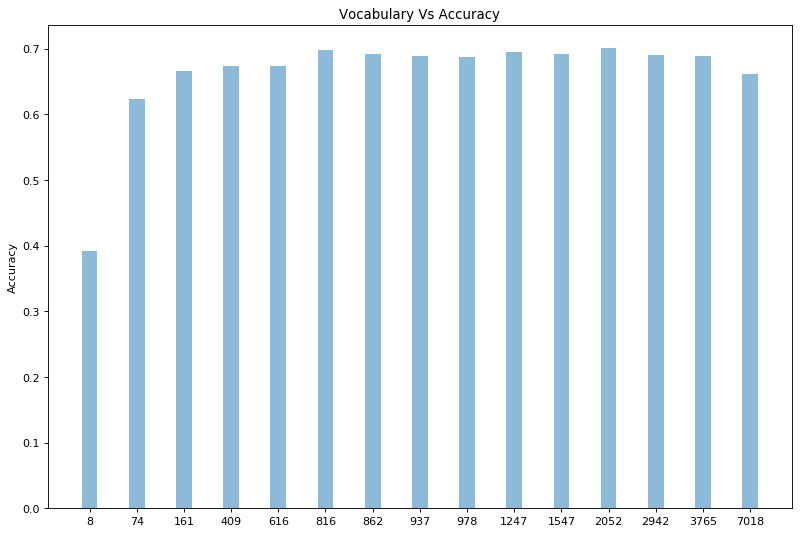

In [232]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

y_pos = np.arange(len(feature_count))

plt.bar(3*y_pos, scores,  align='center', alpha=0.5, width = 1.0 ) 
plt.xticks(3*y_pos, feature_count)
plt.ylabel('Accuracy')
plt.title('Vocabulary Vs Accuracy')


** Answer** 
- We see that as we increase the Value of C, the number of non-zero features increases.
- This can be attributed to the fact that as the regularization strength decrease, the number of non zero coefficient features increase. We See that there isn't a lot of improvement in the performance after a certain value of C. 
- In fact after a certain value the performance of the model decreases as we add more features.

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [181]:
def P7(data, vocab,analyzer, min_df, ngram_range , details, preprocessor, stop_words):
    feat_vect = TfidfVectorizer(vocabulary=vocab, analyzer = analyzer, min_df= min_df, max_features = None,
                                ngram_range = ngram_range, preprocessor = preprocessor, stop_words = stop_words)
    print (feat_vect)
    feat_vect.fit(data)
    dtm_train = feat_vect.transform(data)
    if details == 'Y':
        print (bcolors.BOLD + '\n The size of the vocabulary is:', dtm_train.shape[1])
        print('\n Average length of each example: %.2f' % (dtm_train.nnz /dtm_train.shape[0]))
        print ('\n Amount of Non-Zero occurences: ', dtm_train.nnz)
        print ('\n sparsity: %.2f%%' % (100.0 * dtm_train.nnz /
                                        (dtm_train.shape[0] * dtm_train.shape[1])))
        print ('\n First Feature string: ', feat_vect.get_feature_names()[0])
        print ('\n Last Feature string: ', feat_vect.get_feature_names()[dtm_train.shape[1]-1] + '\n')
    return feat_vect, dtm_train

def P7_LogReg(penalty, data, labels, Cs, ngram_range, preprocessor, validation_ind, stop_words, analyzer, min_df, c_values):
    feat_vec, dtm_train = P7(data, None, analyzer, min_df, ngram_range, 'N', preprocessor, stop_words)
    dtm_dev = feat_vec.transform(dev_data)
    model = LogisticRegression(penalty = penalty, multi_class = 'auto', solver = 'liblinear', C = c_values[0] )
    model.fit(dtm_train, labels)
    print("*** Model Metrics ***")
    print(classification_report(dev_labels, model.predict(dtm_dev)))
    print ("\n" + '*** Confusion Matrix ***')
    print(confusion_matrix(dev_labels, model.predict(dtm_dev)))
    print ("Model Score: %3f" % model.score(dtm_dev, dev_labels))    
    if validation_ind == 'Y':
        gcv = GridSearchCV(model, param_grid = Cs, n_jobs=-1, cv = 5)
        gcv.fit(dtm_train, labels)
        print(bcolors.BOLD + 'Best score for Logistic Regression Classifier :', gcv.best_score_)
        print('Best parameters for Logistic Regression Classifier :', gcv.best_params_)
    return model, dtm_dev

# Using the vocabulary from the corpus of words within the text
P7(train_data, None, 'word', 1, (1,1), 'Y', None, None)

c_values = [100.0]
reg_model, dtm_dev = P7_LogReg('l2', train_data, train_labels, Cs, (1,1), None, 'N', None, 'word',1, c_values)
predicted_probability = (reg_model.predict_proba(dtm_dev))
label_prob = (predicted_probability[np.arange(len(predicted_probability)), dev_labels])
R = np.max(predicted_probability, axis = 1)/label_prob
top3_r = (np.argsort(R)[-5:])
for i in np.nditer(top3_r):
    print (dev_data[i], dev_labels[i], reg_model.predict(dtm_dev[i]), R[i])
    print ('-------------------------------------------')

dev_predicted = reg_model.predict(dtm_dev)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

 The size of the vocabulary is: 26879

 Average length of each example: 96.71

 Amount of Non-Zero occurences:  196700

 sparsity: 0.36%

 First Feature string:  00

 Last Feature string:  zyxel

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
       

**Answer:**
- Looking at the miscategorized texts, we see that the major challenge is identifying atheism vs religion. Since either of these texts will probably consists of the similar features our model has problems classifying them correctly.
- We can look at building another classifier to just classify the labels for Atheism and Religion once the first model predicts to see if there is an increase in correct labeling.
- Another approach would be to increase the weights of the features that have higher weight for classifying the data, but this could lead to overfitting and might not generalize really well for new documents.


(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [203]:
categories_1 = ['alt.atheism', 'talk.religion.misc']
newsgroups_train_1 = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories_1)
newsgroups_test_1 = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories_1)

# Splitting the data into training, dev and test.
num_test_1 = len(newsgroups_test_1.target)
test_data_1, test_labels_1 = newsgroups_test_1.data[int(num_test_1/2):], newsgroups_test_1.target[int(num_test_1/2):]*3
dev_data_1, dev_labels_1 = newsgroups_test_1.data[:int(num_test_1/2)], newsgroups_test_1.target[:int(num_test_1/2)]*3
train_data_1, train_labels_1 = newsgroups_train_1.data, newsgroups_train_1.target*3

print('training label shape:', train_labels_1.shape)
print('test label shape:', test_labels_1.shape)
print('dev label shape:', dev_labels_1.shape)
print('labels names:', newsgroups_train_1.target_names)

training label shape: (857,)
test label shape: (285,)
dev label shape: (285,)
labels names: ['alt.atheism', 'talk.religion.misc']


In [208]:
def P8(data, vocab,analyzer, min_df, ngram_range , details, preprocessor, stop_words):
    feat_vect = TfidfVectorizer(vocabulary=vocab, analyzer = analyzer, min_df= min_df, max_features = None,
                                ngram_range = ngram_range, preprocessor = preprocessor, stop_words = stop_words)
    print (feat_vect)
    feat_vect.fit(data)
    dtm_train = feat_vect.transform(data)
    if details == 'Y':
        print (bcolors.BOLD + '\n The size of the vocabulary is:', dtm_train.shape[1])
        print('\n Average length of each example: %.2f' % (dtm_train.nnz /dtm_train.shape[0]))
        print ('\n Amount of Non-Zero occurences: ', dtm_train.nnz)
        print ('\n sparsity: %.2f%%' % (100.0 * dtm_train.nnz /
                                        (dtm_train.shape[0] * dtm_train.shape[1])))
        print ('\n First Feature string: ', feat_vect.get_feature_names()[0])
        print ('\n Last Feature string: ', feat_vect.get_feature_names()[dtm_train.shape[1]-1] + '\n')
    return feat_vect, dtm_train

def P8_LogReg(penalty, data, labels, Cs, ngram_range, preprocessor, validation_ind, stop_words, analyzer, min_df, c_values):
    feat_vec, dtm_train = P8(data, None, analyzer, min_df, ngram_range, 'N', preprocessor, stop_words)
    dtm_dev = feat_vec.transform(dev_data_1)
    model = LogisticRegression(penalty = penalty, multi_class = 'auto', solver = 'liblinear', C = c_values[0] )
    model.fit(dtm_train, labels)
    print("*** Model Metrics ***")
    print(classification_report(dev_labels_1, model.predict(dtm_dev)))
    print ("\n" + '*** Confusion Matrix ***')
    print(confusion_matrix(dev_labels_1, model.predict(dtm_dev)))
    print ("Model Score: %3f" % model.score(dtm_dev, dev_labels_1))    
    if validation_ind == 'Y':
        gcv = GridSearchCV(model, param_grid = Cs, n_jobs=-1, cv = 5)
        gcv.fit(dtm_train, labels)
        print(bcolors.BOLD + 'Best score for Logistic Regression Classifier :', gcv.best_score_)
        print('Best parameters for Logistic Regression Classifier :', gcv.best_params_)
    return model, dtm_dev, feat_vec

# Using the vocabulary from the corpus of words within the text
P8(train_data_1, None, 'word', 1, (1,1), 'Y', None, 'english')

c_values = [100.0]
reg_model_new, dtm_dev_new, feat_vect_new = P8_LogReg('l2', train_data_1, train_labels_1, Cs, (1,1), None, 'N', None, 'word',1, c_values)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

 The size of the vocabulary is: 13389

 Average length of each example: 64.91

 Amount of Non-Zero occurences:  55625

 sparsity: 0.48%

 First Feature string:  00

 Last Feature string:  zus

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
     

In [210]:
# Identify the indexes that are predicted Atheism and Religion
dev_indx = np.isin(dev_predicted, [0,3])

dev_data_new = list(np.array(dev_data)[dev_indx])
dev_labels_new = list(np.array(dev_labels)[dev_indx])
#Use the feature vettor we built in the second example for transforming the data
dtm_dev_new = feat_vect_new.transform(dev_data_new)
reg_model_new.predict(dtm_dev_new)
print("*** Model Metrics ***")
print ("The Accuracy for the Model is :", reg_model_new.score(dtm_dev_new, dev_labels_new))
print(classification_report(dev_labels_new, reg_model_new.predict(dtm_dev_new)))


*** Model Metrics ***
The Accuracy for the Model is : 0.6753731343283582
              precision    recall  f1-score   support

           0       0.67      0.76      0.72       135
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        14
           3       0.68      0.70      0.69       112

   micro avg       0.68      0.68      0.68       268
   macro avg       0.34      0.36      0.35       268
weighted avg       0.62      0.68      0.65       268



** Answer**
- We built another model, just using the training data for Atheism and Religion. Once we identify, we fit the data to identify the features.
- We use the second model to just classify the data for these categories. When we combine both of them, we see that there is an increase in the performance of classification slightly.